In [24]:
import json
import yaml
import os
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display, HTML
config = yaml.safe_load(open("/gscratch/balazinska/enhaoz/VOCAL-UDF/configs/config.yaml", "r"))

import re
from datetime import datetime
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

In [25]:
def prepare_data(dataset, query_class_names, num_missing_udfs, question_ids, run_ids, vocal_udf_config_name):
    def _model_udf_generation_helper(lines, i):
        # model-udf generation (data labeling)
        while i < len(lines):
            if "+++++++++++++++++++++++++++++++++++++++++++++++" in lines[i]:
                datetime_str = re.search(r"\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d{3}", lines[i]).group()

                # Convert the extracted string to a datetime object
                dt_format = "%Y-%m-%d %H:%M:%S,%f"
                start_datetime = datetime.strptime(datetime_str, dt_format)
                for j in range(i+1, len(lines)):
                    if "Processing train data" in lines[j]:
                        datetime_str = re.search(r"\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d{3}", lines[j]).group()
                        end_datetime = datetime.strptime(datetime_str, dt_format)
                        data.append((dataset, query_class_name, question_id, run_id, "model gen.", "data labeling", (end_datetime - start_datetime).total_seconds()))
                        break
                i = j
                break
            i += 1
        if i == len(lines):
            raise Exception("Model UDF generation (data labeling) not completed")

        # model-udf generation (model training)
        while i < len(lines):
            if "Processing train data" in lines[i]:
                datetime_str = re.search(r"\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d{3}", lines[i]).group()

                # Convert the extracted string to a datetime object
                dt_format = "%Y-%m-%d %H:%M:%S,%f"
                start_datetime = datetime.strptime(datetime_str, dt_format)
                for j in range(i+1, len(lines)):
                    if "test with best model:" in lines[j]:
                        datetime_str = re.search(r"\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d{3}", lines[j]).group()
                        end_datetime = datetime.strptime(datetime_str, dt_format)
                        data.append((dataset, query_class_name, question_id, run_id, "model gen.", "model training", (end_datetime - start_datetime).total_seconds()))
                        break
                i = j
                break
            i += 1
        if i == len(lines):
            raise Exception("Model UDF generation (model training) not completed")

        # model-udf generation (active learning)
        while i < len(lines):
            if "test with best model:" in lines[i]:
                datetime_str = re.search(r"\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d{3}", lines[i]).group()

                # Convert the extracted string to a datetime object
                dt_format = "%Y-%m-%d %H:%M:%S,%f"
                start_datetime = datetime.strptime(datetime_str, dt_format)
                for j in range(i+1, len(lines)):
                    if "iter 0: SamplingStrategy" in lines[j]:
                        return i, False
                    elif "Active learning round:" in lines[j]:
                        datetime_str = re.search(r"\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d{3}", lines[j]).group()
                        end_datetime = datetime.strptime(datetime_str, dt_format)
                        data.append((dataset, query_class_name, question_id, run_id, "model gen.", "active learning", (end_datetime - start_datetime).total_seconds()))
                        break
                i = j
                break
            i += 1
        if i == len(lines):
            raise Exception("Model UDF generation not completed")
        return i, True

    def _udf_generation_helper(lines, i):
        # program-udf generation
        while i < len(lines):
            if "Implementing UDF:" in lines[i]:
                datetime_str = re.search(r"\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d{3}", lines[i]).group()

                # Convert the extracted string to a datetime object
                dt_format = "%Y-%m-%d %H:%M:%S,%f"
                start_datetime = datetime.strptime(datetime_str, dt_format)
                for j in range(i+1, len(lines)):
                    if "filtered_objects:" in lines[j]:
                        for k in range(j-1, i, -1):
                            if "vocaludf.udf_proposer" in lines[k]:
                                _line = lines[k]
                                break
                        datetime_str = re.search(r"\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d{3}", _line).group()
                        end_datetime = datetime.strptime(datetime_str, dt_format)
                        data.append((dataset, query_class_name, question_id, run_id, "program gen.", "program gen.", (end_datetime - start_datetime).total_seconds()))
                        break
                i = k + 1
                break
            if "system_message:" in lines[i]:
                return i, False
            i += 1
        if i == len(lines):
            raise Exception("Program UDF generation not completed")

        # model-udf generation (image sampling)
        while i < len(lines):
            if "filtered_objects:" in lines[i]:
                datetime_str = re.search(r"\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d{3}", lines[i]).group()

                # Convert the extracted string to a datetime object
                dt_format = "%Y-%m-%d %H:%M:%S,%f"
                start_datetime = datetime.strptime(datetime_str, dt_format)
                for j in range(i+1, len(lines)):
                    if "+++++++++++++++++++++++++++++++++++++++++++++++" in lines[j]:
                        datetime_str = re.search(r"\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d{3}", lines[j]).group()
                        end_datetime = datetime.strptime(datetime_str, dt_format)
                        data.append((dataset, query_class_name, question_id, run_id, "model gen.", "frame loading", (end_datetime - start_datetime).total_seconds()))
                        break
                i = j
                break
            i += 1
        if i == len(lines):
            raise Exception("Model UDF generation (image sampling) not completed")

        # model-udf generation
        is_model_udf_generation_stage = True
        while is_model_udf_generation_stage:
            i, is_model_udf_generation_stage = _model_udf_generation_helper(lines, i)
        if i == len(lines):
            raise Exception("Model UDF generation not completed")

        # udf selection (processing frames)
        while i < len(lines):
            if "Processing frames:" in lines[i]:
                datetime_str = re.search(r"\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d{3}", lines[i]).group()

                # Convert the extracted string to a datetime object
                dt_format = "%Y-%m-%d %H:%M:%S,%f"
                start_datetime = datetime.strptime(datetime_str, dt_format)
                for j in range(i+1, len(lines)):
                    if "iter 0: SamplingStrategy" in lines[j]:
                        datetime_str = re.search(r"\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d{3}", lines[j]).group()
                        end_datetime = datetime.strptime(datetime_str, dt_format)
                        data.append((dataset, query_class_name, question_id, run_id, "udf selection", "frame loading", (end_datetime - start_datetime).total_seconds()))
                        break
                i = j
                break
            i += 1
        if i == len(lines):
            raise Exception("UDF selection (processing frames) not completed")

        # udf selection
        while i < len(lines):
            if "iter 0: SamplingStrategy" in lines[i]:
                datetime_str = re.search(r"\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d{3}", lines[i]).group()

                # Convert the extracted string to a datetime object
                dt_format = "%Y-%m-%d %H:%M:%S,%f"
                start_datetime = datetime.strptime(datetime_str, dt_format)
                for j in range(i+1, len(lines)):
                    if "compute test F1 score" in lines[j]:
                        datetime_str = re.search(r"\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d{3}", lines[j]).group()
                        end_datetime = datetime.strptime(datetime_str, dt_format)
                        data.append((dataset, query_class_name, question_id, run_id, "udf selection", "udf selection", (end_datetime - start_datetime).total_seconds()))
                        break
                i = j
                break
            i += 1
        if i == len(lines):
            raise Exception("UDF selection not completed")

        # udf selection (computing test F1 score)
        while i < len(lines):
            if "compute test F1 score" in lines[i]:
                datetime_str = re.search(r"\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d{3}", lines[i]).group()

                # Convert the extracted string to a datetime object
                dt_format = "%Y-%m-%d %H:%M:%S,%f"
                start_datetime = datetime.strptime(datetime_str, dt_format)
                for j in range(i+1, len(lines)):
                    pattern = r"positive: (-?\d+), negative: (-?\d+)"
                    match = re.search(pattern, lines[j])
                    if match:
                        if "UDFCandidate" in lines[j+1]:
                            datetime_str = re.search(r"\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d{3}", lines[j]).group()
                            end_datetime = datetime.strptime(datetime_str, dt_format)
                            end_index = j + 1
                        else:
                            data.append((dataset, query_class_name, question_id, run_id, "udf selection", "computing test score", (end_datetime - start_datetime).total_seconds()))
                            break
                i = end_index
                break
            i += 1
        if i == len(lines):
            raise Exception("UDF selection (computing test F1 score) not completed")

        # udf selection (computing train F1 score)
        datetime_str = re.search(r"\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d{3}", lines[i]).group()
        dt_format = "%Y-%m-%d %H:%M:%S,%f"
        start_datetime = datetime.strptime(datetime_str, dt_format)
        while i < len(lines):
            if "[Selected]: " in lines[i]:
                datetime_str = re.search(r"\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d{3}", lines[i]).group()
                end_datetime = datetime.strptime(datetime_str, dt_format)
                data.append((dataset, query_class_name, question_id, run_id, "udf selection", "udf selection", (end_datetime - start_datetime).total_seconds()))
                break
            i += 1
        if i == len(lines):
            raise Exception("UDF selection (computing train F1 score) not completed")

        return i, True

    data = [] # (dataset, query_class_name, question_id, run_id, type, subtype, time)
    for query_class_name in query_class_names:
        for run_id in run_ids:
            for question_id in question_ids:
                # try:
                print(f"query_class_name={query_class_name}, question_id={question_id}, run_id={run_id}")
                with open(os.path.join(config['log_dir'], "udf_generation", dataset, query_class_name, f"num_missing_udfs={num_missing_udfs}", vocal_udf_config_name, f"qid={question_id}-run={run_id}.log"), "r") as f:
                    lines = f.readlines()
                # Total generation time
                datetime_str = re.search(r"\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d{3}", lines[0]).group()
                dt_format = "%Y-%m-%d %H:%M:%S,%f"
                start_datetime = datetime.strptime(datetime_str, dt_format)
                datetime_str = re.search(r"\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d{3}", lines[-1]).group()
                end_datetime = datetime.strptime(datetime_str, dt_format)
                data.append((dataset, query_class_name, question_id, run_id, "total generation", "total generation", (end_datetime - start_datetime).total_seconds()))

                i = 0
                # Query parsing
                # print("query parsing")
                while i < len(lines):
                    if "system_message" in lines[i]:
                        datetime_str = re.search(r"\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d{3}", lines[i]).group()

                        # Convert the extracted string to a datetime object
                        dt_format = "%Y-%m-%d %H:%M:%S,%f"
                        start_datetime = datetime.strptime(datetime_str, dt_format)
                        for j in range(i+1, len(lines)):
                            if "vocaludf.query_parser - DEBUG - flag " in lines[j]:
                                datetime_str = re.search(r"\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d{3}", lines[j]).group()
                                end_datetime = datetime.strptime(datetime_str, dt_format)
                                data.append((dataset, query_class_name, question_id, run_id, "query parsing", "query parsing", (end_datetime - start_datetime).total_seconds()))
                                break
                        i = j
                        break
                    i += 1
                if i == len(lines):
                    raise Exception("Query parsing not completed")

                parser_flag = False
                while i < len(lines):
                    if "parse_yes" in lines[i]:
                        parser_flag = True
                        break
                    elif "parse_no" in lines[i]:
                        break
                    i += 1
                if i == len(lines):
                    raise Exception("Parser flag not found")
                if not parser_flag:
                    # Create tables
                    # print("table creation")
                    while i < len(lines):
                        if "Create one_object table:" in lines[i]:
                            for j in range(i+1, len(lines)):
                                if "Proposing new UDFs" in lines[j]:
                                    break
                            i = j
                            break
                        i += 1
                    if i == len(lines):
                        raise Exception("Table creation not completed")
                    # Get the time of table creation from `table_creation` folder
                    with open(os.path.join(config['log_dir'], "table_creation", dataset, query_class_name, f"num_missing_udfs={num_missing_udfs}", vocal_udf_config_name, f"qid={question_id}-run={run_id}.log"), "r") as f:
                        table_creation_lines = f.readlines()
                        # print("query execution")
                        datetime_str = re.search(r"\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d{3}", table_creation_lines[0]).group()

                        # Convert the extracted string to a datetime object
                        dt_format = "%Y-%m-%d %H:%M:%S,%f"
                        start_datetime = datetime.strptime(datetime_str, dt_format)
                        for table_creation_line in table_creation_lines:
                            if "Peak memory usuage" in table_creation_line:
                                datetime_str = re.search(r"\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d{3}", table_creation_line).group()
                                end_datetime = datetime.strptime(datetime_str, dt_format)
                                data.append((dataset, query_class_name, question_id, run_id, "table creation", "table creation", (end_datetime - start_datetime).total_seconds()))
                                break

                    # UDF proposal
                    # print("udf proposal")
                    while i < len(lines):
                        if "Proposing new UDFs" in lines[i]:
                            datetime_str = re.search(r"\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d{3}", lines[i]).group()

                            # Convert the extracted string to a datetime object
                            dt_format = "%Y-%m-%d %H:%M:%S,%f"
                            start_datetime = datetime.strptime(datetime_str, dt_format)
                            for j in range(i+1, len(lines)):
                                if "filtering out functions that are already registered" in lines[j]:
                                    datetime_str = re.search(r"\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d{3}", lines[j]).group()
                                    end_datetime = datetime.strptime(datetime_str, dt_format)
                                    data.append((dataset, query_class_name, question_id, run_id, "udf proposal", "udf proposal", (end_datetime - start_datetime).total_seconds()))
                                    break
                            i = j + 1
                            break
                        i += 1
                    if i == len(lines):
                        raise Exception("UDF proposal not completed")

                    # UDF generation
                    is_generation_stage = True
                    while is_generation_stage:
                        # print(f"udf generation, i={i}")
                        i, is_generation_stage = _udf_generation_helper(lines, i)
                    if i == len(lines):
                        raise Exception("UDF generation not completed")

                    # Query parsing
                    # print("query parsing")
                    while i < len(lines):
                        if "system_message" in lines[i]:
                            datetime_str = re.search(r"\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d{3}", lines[i]).group()

                            # Convert the extracted string to a datetime object
                            dt_format = "%Y-%m-%d %H:%M:%S,%f"
                            start_datetime = datetime.strptime(datetime_str, dt_format)
                            for j in range(i+1, len(lines)):
                                if "Peak memory usuage" in lines[j]:
                                    datetime_str = re.search(r"\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d{3}", lines[j]).group()
                                    end_datetime = datetime.strptime(datetime_str, dt_format)
                                    data.append((dataset, query_class_name, question_id, run_id, "query parsing", "query parsing", (end_datetime - start_datetime).total_seconds()))
                                    break
                            i = j + 1
                            break
                        i += 1
                # except Exception as e:
                #     print(e)
                #     continue
                try:
                    with open(os.path.join(config['log_dir'], "query_execution", dataset, query_class_name, f"num_missing_udfs={num_missing_udfs}", vocal_udf_config_name, f"qid={question_id}-run={run_id}.log"), "r") as f:
                        lines = f.readlines()
                        # print("query execution")
                        datetime_str = re.search(r"\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d{3}", lines[0]).group()

                        # Convert the extracted string to a datetime object
                        dt_format = "%Y-%m-%d %H:%M:%S,%f"
                        start_datetime = datetime.strptime(datetime_str, dt_format)
                        for line in lines:
                            if "Peak memory usuage" in line:
                                datetime_str = re.search(r"\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d{3}", line).group()
                                end_datetime = datetime.strptime(datetime_str, dt_format)
                                data.append((dataset, query_class_name, question_id, run_id, "query execution", "query execution", (end_datetime - start_datetime).total_seconds()))
                                break
                except Exception as e:
                    print(e)
                    continue
    return data

In [26]:
data = []

# Clevrer
dataset = "clevrer"
query_class_names = [
    "3_new_udfs_labels",
]
question_ids = list(range(30))
run_ids = list(range(3))
num_missing_udfs = 3
vocal_udf_config_name = "ninterp=10-nparams=5-kwargs=True-pixels=True-pretrained_models=False-ntrain_distill=100-nselection_samples=500-selection=both-labels=user-budget=20-llm_method=gpt4v"

data += prepare_data(dataset, query_class_names, num_missing_udfs, question_ids, run_ids, vocal_udf_config_name)

# CityFlow
dataset = "cityflow"
query_class_names = [
    "unavailable_pred=1-unavailable_attr_pred=1-npred=1-nattr_pred=2-nvars=3-depth=3-max_duration=15-min_npos=74-max_npos=737",
    "unavailable_pred=1-unavailable_attr_pred=1-npred=2-nattr_pred=2-nvars=3-depth=3-max_duration=15-min_npos=74-max_npos=737"
]
question_ids = list(range(15))
run_ids = list(range(3))
num_missing_udfs = 2
vocal_udf_config_name = "ninterp=10-nparams=5-kwargs=True-pixels=False-pretrained_models=False-ntrain_distill=500-nselection_samples=500-selection=both-labels=user-budget=50-llm_method=gpt4v"

data += prepare_data(dataset, query_class_names, num_missing_udfs, question_ids, run_ids, vocal_udf_config_name)

# Charades
dataset = "charades"
query_class_names = [
    "unavailable=2-npred=4-nobj_pred=1-nvars=3-depth=2",
    "unavailable=2-npred=4-nobj_pred=1-nvars=2-depth=2",
    "unavailable=2-npred=3-nobj_pred=1-nvars=2-depth=2"
]
question_ids = list(range(10))
run_ids = list(range(3))
num_missing_udfs = 2
vocal_udf_config_name = "ninterp=10-nparams=5-kwargs=True-pixels=False-pretrained_models=False-ntrain_distill=500-nselection_samples=500-selection=both-labels=user-budget=50-llm_method=gpt4v"

data += prepare_data(dataset, query_class_names, num_missing_udfs, question_ids, run_ids, vocal_udf_config_name)

df = pd.DataFrame(data, columns=["dataset", "query_class_name", "question_id", "run_id", "type", "subtype", "time"])

query_class_name=3_new_udfs_labels, question_id=0, run_id=0
query_class_name=3_new_udfs_labels, question_id=1, run_id=0
query_class_name=3_new_udfs_labels, question_id=2, run_id=0
query_class_name=3_new_udfs_labels, question_id=3, run_id=0
query_class_name=3_new_udfs_labels, question_id=4, run_id=0
query_class_name=3_new_udfs_labels, question_id=5, run_id=0
query_class_name=3_new_udfs_labels, question_id=6, run_id=0
query_class_name=3_new_udfs_labels, question_id=7, run_id=0
query_class_name=3_new_udfs_labels, question_id=8, run_id=0
query_class_name=3_new_udfs_labels, question_id=9, run_id=0
query_class_name=3_new_udfs_labels, question_id=10, run_id=0
query_class_name=3_new_udfs_labels, question_id=11, run_id=0
query_class_name=3_new_udfs_labels, question_id=12, run_id=0
query_class_name=3_new_udfs_labels, question_id=13, run_id=0
query_class_name=3_new_udfs_labels, question_id=14, run_id=0
query_class_name=3_new_udfs_labels, question_id=15, run_id=0
query_class_name=3_new_udfs_labels

In [27]:
# Sanity check
def sanity_check(df):
    df_total_generation = df[df["type"] == "total generation"]
    df_total_generation = df_total_generation[["dataset", "query_class_name", "question_id", "run_id", "time"]]
    df_total_generation = df_total_generation.rename(columns={"time": "total_generation_time"})

    df_filtered = df[(df["type"] != "total generation") & (df["type"] != "query execution")]
    # group by query_class_name, question_id, run_id, and then sum the time column
    df_filtered = df_filtered.groupby(["dataset", "query_class_name", "question_id", "run_id"]).agg({"time": "sum"}).reset_index()
    df_filtered = df_filtered.rename(columns={"time": "sum_time"})
    df_filtered = df_filtered.merge(df_total_generation, on=["dataset", "query_class_name", "question_id", "run_id"], how="left")
    # compute percentage difference as a new column
    df_filtered["percentage"] = (df_filtered["total_generation_time"] - df_filtered["sum_time"]) / df_filtered["total_generation_time"] * 100

    print(df_filtered.to_string())

# sanity_check(df)

In [28]:
# print(df.to_string())

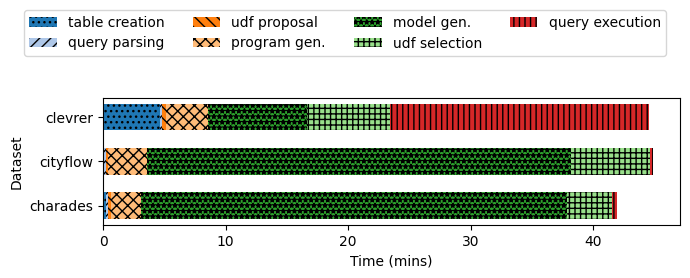

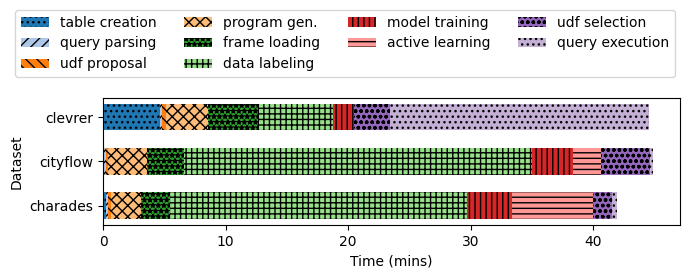

In [29]:
def plot(granularity):
    df_plot = df[(df["type"] != "total generation") & (df["subtype"] != "computing test score")]

    df_plot = df_plot.groupby(["dataset", "query_class_name", "question_id", "run_id", granularity]).agg({"time": "sum"}).reset_index()

    # convert time to minutes
    df_plot.loc[:, "time"] = df_plot["time"] / 60

    cmap = plt.get_cmap('tab20')
    hatch_patterns = ['...', '///', '\\\\\\', 'xxx', '***', '+++', '|||', '---', 'ooo']

    fig, ax = plt.subplots(figsize=(7, 2))

    # Plotting each type as a stack
    if granularity == "type":
        types = ["table creation", "query parsing", "udf proposal", "program gen.", "model gen.", "udf selection", "query execution"]
    elif granularity == "subtype":
        types = ["table creation", "query parsing", "udf proposal", "program gen.", "frame loading", "data labeling", "model training", "active learning", "udf selection", "query execution"]
    else:
        raise Exception("Invalid granularity")
    bottom = pd.Series([0.0] * len(df_plot['dataset'].unique()), index=df_plot['dataset'].unique())
    all_datasets = df_plot['dataset'].unique()
    y_positions = [0, 0.5, 1]
    # Plotting each subtype on top of each other
    for i, type in enumerate(types):
        subset = df_plot[df_plot[granularity] == type].groupby('dataset')['time'].sum().reindex(all_datasets, fill_value=0) / df_plot.groupby('dataset').apply(lambda x: x[['query_class_name', 'question_id', 'run_id']].drop_duplicates().shape[0], include_groups=False)
        ax.barh(y_positions, subset.values, label=type, left=bottom[subset.index], height=0.3, color=cmap(i % 20), hatch=hatch_patterns[i % len(hatch_patterns)], tick_label=subset.index)
        bottom[subset.index] += subset.values

    # Adding labels and title
    ax.set_ylabel('Dataset')
    ax.set_xlabel('Time (mins)')

    # Adding legend
    fig.legend(prop={"size": 10}, loc='upper center', bbox_to_anchor=(0.5, 1.4), fancybox=True, shadow=False, ncol=4)

    # Adjust layout
    fig.tight_layout()
    fig.savefig(f"figures/runtime_{granularity}.pdf", bbox_inches='tight')

    # Show the plot
    plt.show()


plot("type")
plot("subtype")